In [2]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
    $$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
    $$
    where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [4]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int

In [23]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k, k = state
    
    d_k = f.grad(x_k) + g.subgrad(x_k)
    
    next_x_k = x_k - 0.1/np.sqrt(k) * d_k
    
    return SubG_state(next_x_k, k+1)

def SubG_initialize(composite_function, x_zero):
    return SubG_state(x_zero, 1)

In [24]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

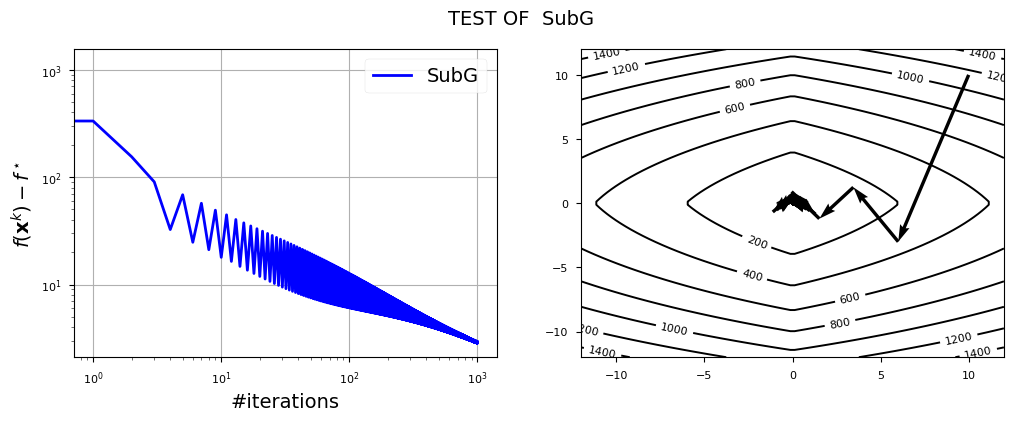

In [25]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 8, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


We know that $prox_{\gamma g_l}(z) = \arg \min_{y \in R^p} \{\Vert y \Vert + \frac{1}{2\gamma} \Vert y - z \Vert^2_2 \}$. By the optimality condition, the solution of this problem should follow $sign(y) + \lambda^{-1}(y - z) = 0$. Now can split this into 

$y > 0 \rightarrow 1 + \lambda^{-1} (y - z) = 0 \rightarrow y = z - \lambda = sign(z)|z| - \lambda \text{ (for z > }\lambda)$

$y < 0 \rightarrow -1 + \lambda^{-1} (y - z) = 0 \rightarrow y = z + \lambda = sign(z)|z| + \lambda \text{ (for z <} -\lambda)$

For $z$ in between this range, we can let $y = 0$. We know that $prox_{\gamma g_l}(x) = z$. Hence, $prox_{\gamma g_l}(x) = \max(|z| - \gamma, 0) \circ sign(z)$, because this value will equal 0 when $-\lambda \leq z \leq \lambda$, $z - \lambda$ when $z > \lambda$, and $z + \lambda$ when $z < \lambda$.

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [65]:
def l1_prox(gamma, z):
    return np.maximum(np.abs(z) - gamma, 0.0) * np.sign(z)

#### Question 4 (5 points)
 
Using the information in Lecture 7 slide 14 fill in the codes of methods `ISTA`.

Note that for a given function `h`, you can computte $prox_{\gamma h}(\mathbf{x})$ by calling `h.prox(gamma, x)` 

In [66]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    alpha: float

In [70]:
def ISTA_update(composite_function, state):
    f, g = composite_function
    x_k, alpha = state
    
    next_x_k = g.prox(alpha, x_k - alpha * f.grad(x_k))
    
    return ISTA_state(next_x_k, alpha)

def ISTA_initialize(composite_function, x_zero):
    f, _ = composite_function
    return ISTA_state(x_zero, 1.0/f.lips_grad)

In [71]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

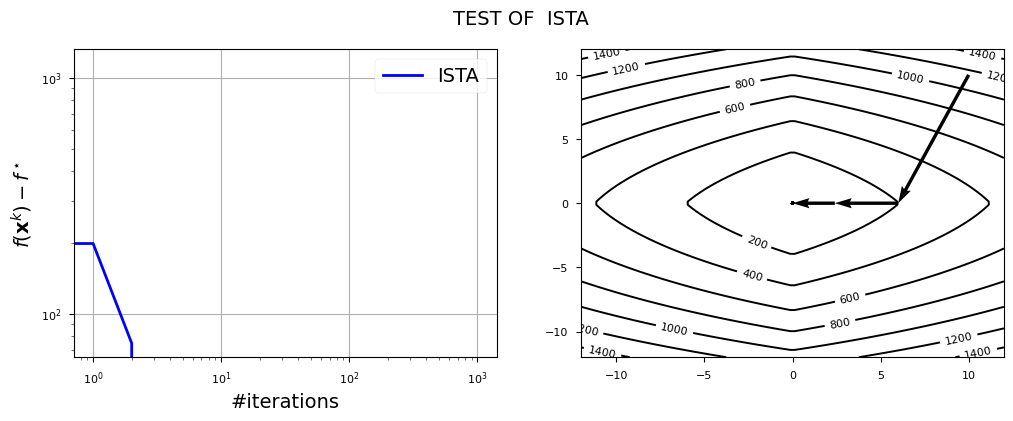

In [72]:
test_composite(ISTA)

#### Question 5  (8 points)

Using the information in Lecture 7, implement `FISTA`.

Adapt it to also handle restarts: You need to implement the so-called __gradient restart condition__ , described in depth in papers such as [this one](http://archive.control.lth.se/media/Staff/PontusGiselsson/publications/gisBoydCDC2014afgm.pdf). Formally, the criterion is given by,
$$\langle \mathbf{y}^{k}-\mathbf{x}^{k+1}, \mathbf{x}^{k+1} - \mathbf{x}^k \rangle > 0,$$
where $k$ is the iteration index. The term $\mathbf{y}^{k}-\mathbf{x}^{k+1}$ can be seen as a gradient, while $\mathbf{x}^{k+1} - \mathbf{x}^k$ is the descent direction of the momentum term. Overall this criterion resets the momentum of FISTA to $0$ when it goes in a bad descent direction. 

In [105]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    t_k: float
    alpha: float

In [112]:
def FISTA_update(composite_function, state):
    f, g = composite_function
    x_k, y_k, t_k, alpha = state
    
    next_x_k = g.prox(alpha, y_k - alpha * f.grad(y_k))
        
    if (y_k - next_x_k).dot(next_x_k - x_k) > 0:
        y_k = x_k
        t_k = 1
        next_x_k = g.prox(alpha, y_k - alpha * f.grad(y_k))
    
    next_t_k = (1 + (4 * t_k**2 + 1)**0.5) / 2
    next_y_k = next_x_k + (t_k - 1)/next_t_k * (next_x_k - x_k)
    
    return FISTA_state(next_x_k, next_y_k, next_t_k, alpha)

def FISTA_initialize(composite_function, x_zero):
    return FISTA_state(x_zero, x_zero, 1.0, 1/composite_function.f.lips_grad)


In [113]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

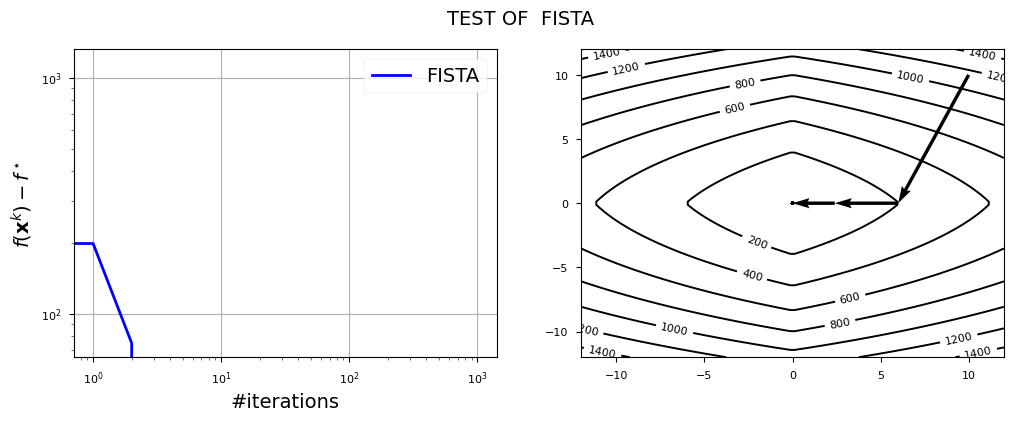

In [114]:
test_composite(FISTA)

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

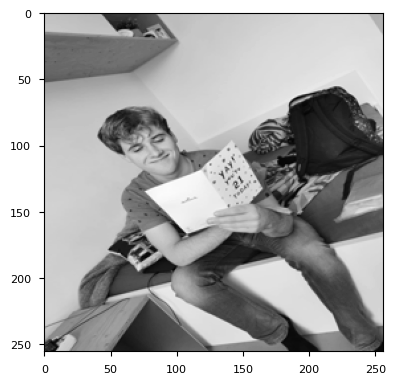

In [231]:
from lib.inpainting import *

image = load("alp.jpg")

With this image in hand, let us subsample it and try to reconstruct the original.

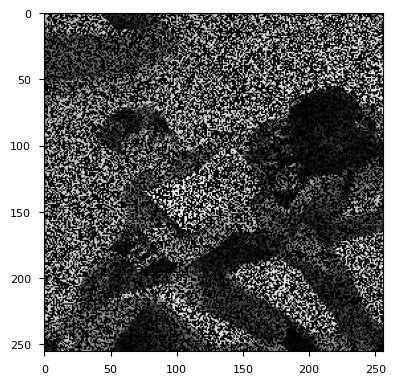

In [232]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [233]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [234]:
def f_l1(alpha):
    return np.linalg.norm(b - P(W_T(alpha)))^2 / 2

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [235]:
def grad_f_l1(alpha):
    return -W(P_T(b - P(W_T(alpha))))

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

We first compute $\nabla^2_\alpha f_{l_1}(\alpha) = W P_\Omega^T P_\Omega W^T$. We know that $P_\Omega$ is a matrix that selects $n$ unique cells from a vectorized image $x$. This means that $P_\Omega$ will have only one 1-valued cell per row and the rest all zeros. Furthermore, since all selected cells from $x$ are unique, the rows of $P_\Omega$ will always be unique. Hence, $P_\Omega$ is an orthogonal matrix. Then, $\nabla^2_\alpha f_{l_1}(\alpha) = W P_\Omega^T P_\Omega W^T = W W^T = I$, since both $W$ and $P_\Omega$ are orthogonal. This means that $\nabla^2_\alpha f_{l_1}(\alpha) \preccurlyeq 1$, meaning $L = 1$.

In [252]:
lips_grad_f_l1 = 1

We have all the necessary ingredients to define the smooth part of our composite objective:

In [253]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [254]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [255]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [256]:
from lib.inpainting import solve_composite

__(e)__ (6 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Set the number of iterations around `1000`, and select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

In [257]:
out = solve_composite(FISTA, composite_objective, 2, max_iterations=1000)
flat_image_out = W_T(out)
image_out = flat_image_out.reshape(256, 256)

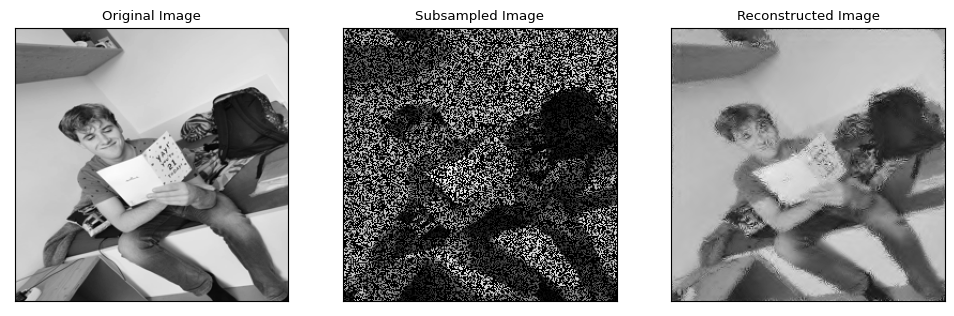

In [258]:
show(true = image, subsampled=subsampled, estimated=image_out)